# Beijing Air Quality Forecasting Starter Notebook

In [187]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [188]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [189]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [190]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [191]:
# Efficient fillna with mean (same as before)
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# Feature Engineering - Add lagged features and other engineered features
def add_lagged_features(df, lags=[1, 2, 3, 6, 12, 24]):
    """Add lagged features for all numeric columns"""
    df_copy = df.copy()
    
    # Add lagged features
    for lag in lags:
        for col in df.columns:
            if col not in ['pm2.5', 'No']:  # Don't lag target or ID
                df_copy[f'{col}_lag_{lag}'] = df[col].shift(lag)
    
    # Add rolling window features
    for window in [3, 6, 12, 24]:
        for col in df.columns:
            if col not in ['pm2.5', 'No']:
                df_copy[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
                df_copy[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()
                df_copy[f'{col}_rolling_max_{window}'] = df[col].rolling(window=window).max()
                df_copy[f'{col}_rolling_min_{window}'] = df[col].rolling(window=window).min()
    
    # Add time-based features
    df_copy['hour'] = df_copy.index.hour
    df_copy['day_of_week'] = df_copy.index.dayofweek
    df_copy['month'] = df_copy.index.month
    df_copy['is_weekend'] = (df_copy.index.dayofweek >= 5).astype(int)
    df_copy['season'] = ((df_copy.index.month % 12 + 3) // 3).map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})
    
    # Encode categorical season feature
    season_dummies = pd.get_dummies(df_copy['season'], prefix='season')
    df_copy = pd.concat([df_copy.drop('season', axis=1), season_dummies], axis=1)
    
    # Add interaction features (example with key meteorological variables)
    if 'TEMP' in df.columns and 'DEWP' in df.columns:
        df_copy['temp_dewp_diff'] = df_copy['TEMP'] - df_copy['DEWP']
    if 'TEMP' in df.columns and 'PRES' in df.columns:
        df_copy['temp_pres_interaction'] = df_copy['TEMP'] * df_copy['PRES']
    if 'WSPM' in df.columns and 'TEMP' in df.columns:
        df_copy['wind_temp_interaction'] = df_copy['WSPM'] * df_copy['TEMP']
    
    return df_copy

# Apply feature engineering
print("Adding lagged features and engineered features...")
train = add_lagged_features(train)
test = add_lagged_features(test)

# Remove rows with NaN values created by lagging (keep your fillna approach)
train.dropna(inplace=True)
test.fillna(test.mean(), inplace=True)  # For test set, fill remaining NaNs with mean

# Optional: convert to float32 for memory efficiency
train = train.astype(np.float32)
test = test.astype(np.float32)

# Your existing variable assignments (keeping exactly as you had them)
X_train = train.drop(['pm2.5', 'No'], axis=1).values 
y_train = train['pm2.5'].values 

# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

print(f"Original features: {len([col for col in train.columns if col not in ['pm2.5', 'No']])} -> Enhanced features: {X_train.shape[2]}")
print(f"Training data shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")

Adding lagged features and engineered features...


/tmp/ipykernel_150298/327019887.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col}_rolling_mean_{window}'] = df[col].rolling(window=window).mean()
/tmp/ipykernel_150298/327019887.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'{col}_rolling_std_{window}'] = df[col].rolling(window=window).std()
/tmp/ipykernel_150298/327019887.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

Original features: 217 -> Enhanced features: 217
Training data shape: (30652, 1, 217)
Target shape: (30652,)


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Bidirectional, LeakyReLU, GRU
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np

# =============================
# STANDARDIZE DATA
# =============================
num_samples, timesteps, num_features = X_train.shape

X_train_flat = X_train.reshape(-1, num_features)
scaler = StandardScaler().fit(X_train_flat)
X_train_scaled_flat = scaler.transform(X_train_flat)
X_train = X_train_scaled_flat.reshape(num_samples, timesteps, num_features)

# =============================
# FIXED DEEP MODEL ARCHITECTURE
# =============================
def create_deep_pattern_capturing_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Initial convolutional layers for local pattern extraction
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    # x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    # First LSTM layer
    lstm1 = Bidirectional(LSTM(128, return_sequences=True, 
                             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))(x)
    lstm1 = BatchNormalization()(lstm1)
    lstm1 = Dropout(0.4)(lstm1)
    
    # Second LSTM layer with matching dimensions
    lstm2 = Bidirectional(LSTM(128, return_sequences=True,  # Same units for residual connection
                             kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))(lstm1)
    lstm2 = BatchNormalization()(lstm2)
    lstm2 = Dropout(0.4)(lstm2)
    
    # Residual connection with matching dimensions
    if lstm1.shape[-1] != lstm2.shape[-1]:
        residual = Conv1D(lstm2.shape[-1], kernel_size=1, padding='same')(lstm1)
    else:
        residual = lstm1
    
    x = tf.keras.layers.add([lstm2, residual])
    
    # GRU layer
    gru = Bidirectional(GRU(64, return_sequences=True))(x)
    gru = BatchNormalization()(gru)
    gru = Dropout(0.3)(gru)
    
    # Global pooling
    pooled = GlobalAveragePooling1D()(gru)
    
    # Dense layers with regularization
    x = Dense(128, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(pooled)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(32)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Alternative simpler architecture if the above still has issues
def create_robust_model(input_shape):
    model = Sequential([
        # Convolutional layers for pattern extraction
        Conv1D(64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        # MaxPooling1D(pool_size=1),
        Dropout(0.3),
        
        Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        # Bidirectional LSTM layers
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))),
        BatchNormalization(),
        Dropout(0.4),
        
        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.4),
        
        # GRU layer
        Bidirectional(GRU(32, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.3),
        
        # Dense layers
        Dense(128, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(64),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(32),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        
        # Output layer
        Dense(1)
    ])
    return model

# Create model - try the simpler version first
try:
    model = create_deep_pattern_capturing_model((X_train.shape[1], X_train.shape[2]))
except Exception as e:
    print(f"Complex model failed: {e}")
    print("Creating robust model instead...")
    model = create_robust_model((X_train.shape[1], X_train.shape[2]))

# =============================
# OPTIMIZER WITH GRADIENT CLIPPING
# =============================
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7,
    clipnorm=1.0,
    # clipvalue=0.5
)

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)

# =============================
# ENHANCED CALLBACKS
# =============================
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=0.001,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1,
        cooldown=2
    ),
    ModelCheckpoint(
        "best_deep_pattern_model.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    )
]

# =============================
# MODEL SUMMARY
# =============================
model.summary()


/home/lscblack/miniconda3/envs/ml-gpu/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 1, 217)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 1, 64)     │     41,728 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 64)     │        256 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_69          │ (None, 1, 64)     │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 1, 128)    │     24,704 │ dropout_69[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 128)    │        512 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_70          │ (None, 1, 128)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_41    │ (None, 1, 256)    │    263,168 │ dropout_70[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 256)    │      1,024 │ bidirectional_41… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_71          │ (None, 1, 256)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_42    │ (None, 1, 256)    │    394,240 │ dropout_71[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 256)    │      1,024 │ bidirectional_42… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_72          │ (None, 1, 256)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 1, 256)    │          0 │ dropout_72[0][0], │
│                     │                   │            │ dropout_71[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_43    │ (None, 1, 128)    │    123,648 │ add_7[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 128)    │        512 │ bidirectional_43… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_73          │ (None, 1, 128)    │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 878,465 (3.35 MB)

 Trainable params: 876,417 (3.34 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [196]:
# Train the model with professional configuration
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=200,            # Increased epochs with early stopping
    batch_size=16,
    callbacks=callbacks,   # Use the defined callbacks for optimization
    verbose=1,             # Show progress bar
    shuffle=True         # Important: Don't shuffle time series data
)
print("Model training completed with early stopping and learning rate scheduling")

Epoch 1/200
1149/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4568.1562 - mae: 46.2903 - mse: 4567.7988
Epoch 1: val_loss improved from 4114.60303 to 4017.32153, saving model to best_deep_pattern_model.h5


1150/1150 ━━━━━━━━━━━━━━━━━━━━ 27s 23ms/step - loss: 4656.0732 - mae: 46.3849 - mse: 4655.7153 - val_loss: 4017.3215 - val_mae: 41.5449 - val_mse: 4016.9519 - learning_rate: 5.0000e-04
Epoch 2/200
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4336.2373 - mae: 45.2629 - mse: 4335.8662
Epoch 2: val_loss did not improve from 4017.32153
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 4506.0151 - mae: 45.6047 - mse: 4505.6401 - val_loss: 4044.1177 - val_mae: 42.0955 - val_mse: 4043.7341 - learning_rate: 5.0000e-04
Epoch 3/200
1149/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4365.1489 - mae: 45.2666 - mse: 4364.7656
Epoch 3: val_loss improved from 4017.32153 to 3949.99048, saving model to best_deep_pattern_model.h5


1150/1150 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 4340.2700 - mae: 44.7236 - mse: 4339.8843 - val_loss: 3949.9905 - val_mae: 41.8412 - val_mse: 3949.5918 - learning_rate: 5.0000e-04
Epoch 4/200
1148/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4181.3760 - mae: 44.4383 - mse: 4180.9775
Epoch 4: val_loss did not improve from 3949.99048
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 4244.4570 - mae: 44.3792 - mse: 4244.0532 - val_loss: 4170.8760 - val_mae: 42.0875 - val_mse: 4170.4668 - learning_rate: 5.0000e-04
Epoch 5/200
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4003.9548 - mae: 43.2413 - mse: 4003.5437
Epoch 5: val_loss did not improve from 3949.99048
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - loss: 4116.9224 - mae: 43.5894 - mse: 4116.5103 - val_loss: 4071.4595 - val_mae: 41.6480 - val_mse: 4071.0388 - learning_rate: 5.0000e-04
Epoch 6/200
1149/1150 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3929.8271 - mae: 43.1949 - mse: 3929.4016
Epoch 6: val_loss did not i

958/958 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


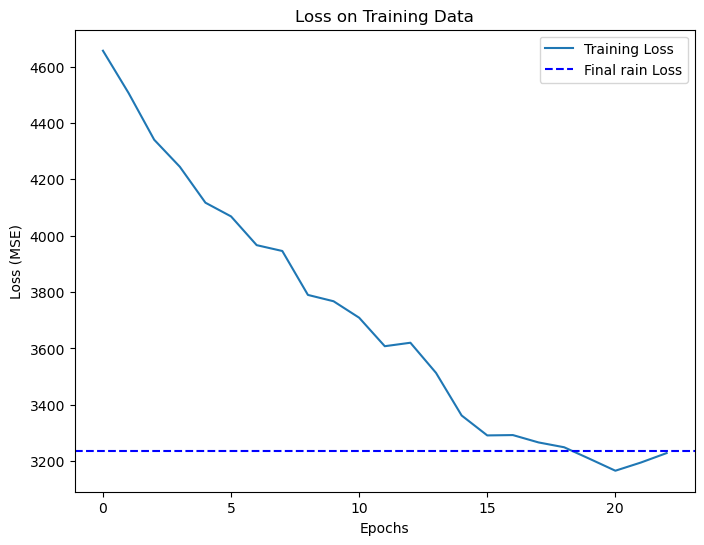

Final Training Loss (MSE): 3237.67822265625


In [205]:
# Calculate training loss
train_predictions = model.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

Final Training Loss (MSE): 3183.20458984375

Final Training Loss (MSE): 3245.11181640625

final traing 3295.55712890625

Final Training Loss (MSE): 5518.2392578125

Final Training Loss (MSE): 5740.1162109375

Final Training Loss (MSE): 5905.39892578125

Final Training Loss (MSE): 7489.71875

Final Training Loss (MSE): 10908.271484375

Final Training Loss (MSE): 7389.98681640625 (0.01)

Final Training Loss (MSE): 6858.7236328125

Final Training Loss (MSE): 7189.4912109375 ()

In [204]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

def save_submission(predictions, experiment_name, test_index, notes=""):
    """
    Save model predictions to CSV in a structured format compatible with Kaggle.
    
    Args:
        predictions (array-like): Model predictions.
        experiment_name (str): Name/ID of the experiment.
        test_index (pd.Index or pd.DatetimeIndex): Index for test data rows.
        notes (str, optional): Any additional notes to track.
        
    Returns:
        tuple: (fixed_filename, submission DataFrame)
    """
    os.makedirs('submissions', exist_ok=True)
    
    # Ensure predictions are proper format, non-negative, integer, and NaN-safe
    predictions = np.nan_to_num(np.maximum(np.array(predictions).flatten(), 0))
    predictions = np.round(predictions).astype(int)
    
    # Convert test index to datetime strings with no leading zero in hour
    row_ids = pd.to_datetime(test_index).strftime('%Y-%m-%d %-H:%M:%S')
    
    submission = pd.DataFrame({
        'row ID': row_ids,
        'pm2.5': predictions
    })
    
    # Sort by 'row ID' for consistency
    submission = submission.sort_values(by='row ID')
    
    # Fixed filename for Kaggle submission
    fixed_filename = 'submissions/subm_fixed.csv'
    submission.to_csv(fixed_filename, index=False)
    
    # Timestamped file for tracking experiments
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    tracking_filename = f'submissions/{timestamp}_{experiment_name}.csv'
    submission.to_csv(tracking_filename, index=False)
    
    # Print summary statistics
    print(f"Submission saved: {fixed_filename}")
    print(f"Predictions - Min: {predictions.min()}, Max: {predictions.max()}, Mean: {predictions.mean():.1f}")
    if notes:
        print(f"Notes: {notes}")
    
    return fixed_filename, submission

print("submission system ready")


submission system ready
